# Approach 1: Statistical & Ensemble-Based Anomaly Detection

This approach focuses on statistical methods and ensemble techniques for detecting anomalous shopping baskets.

## Key Components:

1. **Feature Engineering**: Create meaningful numerical features from basket data
2. **Statistical Outlier Detection**: IQR-based and percentile-based methods
3. **Ensemble Methods**: Isolation Forest, Local Outlier Factor, One-Class SVM
4. **Composite Scoring**: Combine multiple anomaly indicators

## Advantages:

- Interpretable results
- Fast computation
- Robust to missing values
- Good baseline performance


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Anomaly detection libraries
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from scipy import stats

warnings.filterwarnings("ignore")


# Set paths
DATA_PATH = Path("data/")
RESULTS_PATH = Path("results/")
RESULTS_PATH.mkdir(exist_ok=True)

# Set style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

In [2]:
# Load data
train_df = pd.read_csv(DATA_PATH / "X_train_G3tdtEn.csv")
test_df = pd.read_csv(DATA_PATH / "X_test_8skS2ey.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Identify column types
item_cols = [col for col in train_df.columns if col.startswith("item")]
price_cols = [col for col in train_df.columns if col.startswith("cash_price")]
make_cols = [col for col in train_df.columns if col.startswith("make")]
model_cols = [col for col in train_df.columns if col.startswith("model")]
goods_code_cols = [col for col in train_df.columns if col.startswith("goods_code")]
nbr_prod_cols = [
    col for col in train_df.columns if col.startswith("Nbr_of_prod_purchas")
]

print(f"\nColumn categories identified:")
print(f"Items: {len(item_cols)}, Prices: {len(price_cols)}, Makes: {len(make_cols)}")
print(
    f"Models: {len(model_cols)}, Codes: {len(goods_code_cols)}, Quantities: {len(nbr_prod_cols)}"
)

Training data shape: (92790, 146)
Test data shape: (23198, 146)

Column categories identified:
Items: 24, Prices: 24, Makes: 24
Models: 24, Codes: 24, Quantities: 24


## Step 1: Advanced Feature Engineering

Create comprehensive features that capture different aspects of shopping behavior that could indicate fraud.


In [3]:
def engineer_features(df):
    """
    Engineer comprehensive features for anomaly detection
    """
    features = pd.DataFrame()
    features["ID"] = df["ID"]

    # Basic basket metrics
    features["nb_items"] = df["Nb_of_items"]
    features["total_basket_value"] = df[price_cols].sum(axis=1)
    features["total_products"] = df[nbr_prod_cols].sum(axis=1)

    # Price-based features
    features["avg_item_price"] = features["total_basket_value"] / features["nb_items"]
    features["max_item_price"] = df[price_cols].max(axis=1)
    features["min_item_price"] = df[price_cols].min(axis=1)
    features["price_std"] = df[price_cols].std(axis=1)
    features["price_range"] = features["max_item_price"] - features["min_item_price"]

    # Quantity-based features
    features["avg_quantity_per_item"] = (
        features["total_products"] / features["nb_items"]
    )
    features["max_quantity"] = df[nbr_prod_cols].max(axis=1)
    features["quantity_std"] = df[nbr_prod_cols].std(axis=1)

    # Diversity metrics
    unique_items_per_basket = []
    unique_makes_per_basket = []
    unique_codes_per_basket = []

    for idx, row in df.iterrows():
        # Unique item categories
        items = [row[col] for col in item_cols if pd.notna(row[col])]
        unique_items_per_basket.append(len(set(items)))

        # Unique manufacturers
        makes = [row[col] for col in make_cols if pd.notna(row[col])]
        unique_makes_per_basket.append(len(set(makes)))

        # Unique product codes
        codes = [row[col] for col in goods_code_cols if pd.notna(row[col])]
        unique_codes_per_basket.append(len(set(codes)))

    features["unique_items"] = unique_items_per_basket
    features["unique_makes"] = unique_makes_per_basket
    features["unique_codes"] = unique_codes_per_basket

    # Diversity ratios
    features["item_diversity_ratio"] = features["unique_items"] / features["nb_items"]
    features["make_diversity_ratio"] = features["unique_makes"] / features["nb_items"]

    # Price per product ratios
    features["price_per_product"] = (
        features["total_basket_value"] / features["total_products"]
    )

    # Shopping pattern features
    features["items_to_products_ratio"] = (
        features["nb_items"] / features["total_products"]
    )

    # Handle infinite and missing values
    features = features.replace([np.inf, -np.inf], np.nan)

    return features

In [4]:
# Engineer features for both datasets
train_features = engineer_features(train_df)
test_features = engineer_features(test_df)

print("Engineered features:")
print(train_features.columns.tolist())
print(f"\nTraining features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Display feature statistics
print("\nFeature statistics (training data):")
print(train_features.describe())

Engineered features:
['ID', 'nb_items', 'total_basket_value', 'total_products', 'avg_item_price', 'max_item_price', 'min_item_price', 'price_std', 'price_range', 'avg_quantity_per_item', 'max_quantity', 'quantity_std', 'unique_items', 'unique_makes', 'unique_codes', 'item_diversity_ratio', 'make_diversity_ratio', 'price_per_product', 'items_to_products_ratio']

Training features shape: (92790, 19)
Test features shape: (23198, 19)

Feature statistics (training data):
                  ID      nb_items  total_basket_value  total_products  \
count   92790.000000  92790.000000        92790.000000    92790.000000   
mean    57968.969070      1.764479         1234.759554        1.853864   
std     33487.595782      1.462264          771.484197        1.981476   
min         0.000000      1.000000          219.000000        1.000000   
25%     28901.250000      1.000000          779.000000        1.000000   
50%     57961.500000      1.000000         1099.000000        1.000000   
75%     869

## Step 2: Statistical Outlier Detection

Implement multiple statistical methods to identify outliers in different feature dimensions.


In [5]:
def detect_statistical_outliers(features, method="iqr", contamination=0.05):
    """
    Detect statistical outliers using various methods
    """
    outlier_scores = pd.DataFrame()
    outlier_scores["ID"] = features["ID"]

    # Select numerical features (exclude ID)
    numerical_features = features.select_dtypes(include=[np.number]).drop("ID", axis=1)

    if method == "iqr":
        # IQR-based outlier detection for each feature
        for col in numerical_features.columns:
            data = numerical_features[col].dropna()
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outlier_scores[f"{col}_outlier"] = (
                (numerical_features[col] < lower_bound)
                | (numerical_features[col] > upper_bound)
            ).astype(int)

    elif method == "zscore":
        # Z-score based outlier detection
        for col in numerical_features.columns:
            z_scores = np.abs(stats.zscore(numerical_features[col].fillna(0)))
            outlier_scores[f"{col}_outlier"] = (z_scores > 3).astype(int)

    elif method == "percentile":
        # Percentile-based outlier detection
        contamination_per_tail = contamination / 2
        for col in numerical_features.columns:
            data = numerical_features[col].dropna()
            lower_percentile = data.quantile(contamination_per_tail)
            upper_percentile = data.quantile(1 - contamination_per_tail)

            outlier_scores[f"{col}_outlier"] = (
                (numerical_features[col] < lower_percentile)
                | (numerical_features[col] > upper_percentile)
            ).astype(int)

    # Calculate composite outlier score
    outlier_cols = [col for col in outlier_scores.columns if col.endswith("_outlier")]
    outlier_scores["statistical_score"] = outlier_scores[outlier_cols].sum(axis=1)

    return outlier_scores

In [6]:
# Apply statistical outlier detection
print("Applying statistical outlier detection methods...\n")

# IQR-based detection
iqr_outliers = detect_statistical_outliers(train_features, method="iqr")
print(f"IQR method - Outlier score distribution:")
print(iqr_outliers["statistical_score"].value_counts().sort_index())

# Z-score based detection
zscore_outliers = detect_statistical_outliers(train_features, method="zscore")
print(f"\nZ-score method - Outlier score distribution:")
print(zscore_outliers["statistical_score"].value_counts().sort_index())

# Percentile-based detection
percentile_outliers = detect_statistical_outliers(
    train_features, method="percentile", contamination=0.05
)
print(f"\nPercentile method - Outlier score distribution:")
print(percentile_outliers["statistical_score"].value_counts().sort_index())

Applying statistical outlier detection methods...

IQR method - Outlier score distribution:
statistical_score
0     66311
1     10545
2      3673
3      2868
4      1915
5      3741
6      1007
7       830
8       305
9       652
10      450
11      348
12      123
13       14
14        8
Name: count, dtype: int64

Z-score method - Outlier score distribution:
statistical_score
0     82831
1      4378
2      2067
3      1137
4       801
5       820
6       384
7       146
8       100
9        78
10       37
11       11
Name: count, dtype: int64

Percentile method - Outlier score distribution:
statistical_score
0     79072
1      3277
2      3616
3      2304
4      1892
5      1068
6       540
7       380
8       176
9       168
10      117
11       60
12       53
13       44
14       19
15        4
Name: count, dtype: int64


## Step 3: Machine Learning-Based Anomaly Detection

Apply ensemble methods including Isolation Forest, Local Outlier Factor, and One-Class SVM.


In [7]:
def prepare_ml_features(features):
    """
    Prepare features for ML algorithms
    """
    # Select numerical features and handle missing values
    ml_features = features.select_dtypes(include=[np.number]).drop("ID", axis=1)

    # Fill missing values with median
    ml_features = ml_features.fillna(ml_features.median())

    # Remove any remaining infinite values
    ml_features = ml_features.replace([np.inf, -np.inf], np.nan)
    ml_features = ml_features.fillna(0)

    return ml_features


def apply_ml_anomaly_detection(features, contamination=0.05):
    """
    Apply multiple ML-based anomaly detection algorithms
    """
    # Prepare features
    ml_features = prepare_ml_features(features)

    # Scale features
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(ml_features)

    results = pd.DataFrame()
    results["ID"] = features["ID"]

    # 1. Isolation Forest
    print("Applying Isolation Forest...")
    iso_forest = IsolationForest(
        contamination=contamination, random_state=42, n_jobs=-1
    )
    iso_predictions = iso_forest.fit_predict(scaled_features)
    iso_scores = iso_forest.decision_function(scaled_features)

    results["isolation_forest_pred"] = (iso_predictions == -1).astype(int)
    results["isolation_forest_score"] = -iso_scores  # Convert to positive scores

    # 2. Local Outlier Factor
    print("Applying Local Outlier Factor...")
    lof = LocalOutlierFactor(contamination=contamination, n_jobs=-1)
    lof_predictions = lof.fit_predict(scaled_features)
    lof_scores = -lof.negative_outlier_factor_

    results["lof_pred"] = (lof_predictions == -1).astype(int)
    results["lof_score"] = lof_scores

    # 3. One-Class SVM
    print("Applying One-Class SVM...")
    svm = OneClassSVM(nu=contamination, kernel="rbf", gamma="scale")
    svm_predictions = svm.fit_predict(scaled_features)
    svm_scores = svm.decision_function(scaled_features)

    results["svm_pred"] = (svm_predictions == -1).astype(int)
    results["svm_score"] = -svm_scores  # Convert to positive scores

    # Ensemble prediction (majority vote)
    results["ensemble_pred"] = (
        results["isolation_forest_pred"] + results["lof_pred"] + results["svm_pred"]
    )

    # Composite anomaly score (normalized average)
    score_cols = ["isolation_forest_score", "lof_score", "svm_score"]
    for col in score_cols:
        results[f"{col}_norm"] = (results[col] - results[col].min()) / (
            results[col].max() - results[col].min()
        )

    results["composite_ml_score"] = results[[f"{col}_norm" for col in score_cols]].mean(
        axis=1
    )

    return results, scaler

In [8]:
# Apply ML-based anomaly detection
ml_results, feature_scaler = apply_ml_anomaly_detection(
    train_features, contamination=0.05
)

print("ML-based anomaly detection results:")
print(f"Isolation Forest anomalies: {ml_results['isolation_forest_pred'].sum()}")
print(f"LOF anomalies: {ml_results['lof_pred'].sum()}")
print(f"One-Class SVM anomalies: {ml_results['svm_pred'].sum()}")
print(f"\nEnsemble prediction distribution:")
print(ml_results["ensemble_pred"].value_counts().sort_index())

Applying Isolation Forest...
Applying Local Outlier Factor...
Applying One-Class SVM...
ML-based anomaly detection results:
Isolation Forest anomalies: 4640
LOF anomalies: 4632
One-Class SVM anomalies: 4989

Ensemble prediction distribution:
ensemble_pred
0    80648
1    10105
2     1955
3       82
Name: count, dtype: int64


## Step 4: Final Composite Scoring and Ranking

Combine all anomaly detection methods to create a comprehensive anomaly score.


In [9]:
def create_final_anomaly_scores(train_features, statistical_results, ml_results):
    """
    Create final composite anomaly scores
    """
    final_scores = pd.DataFrame()
    final_scores["ID"] = train_features["ID"]

    # Add original features for interpretation
    final_scores["nb_items"] = train_features["nb_items"]
    final_scores["total_basket_value"] = train_features["total_basket_value"]
    final_scores["total_products"] = train_features["total_products"]
    final_scores["unique_items"] = train_features["unique_items"]

    # Statistical scores (normalized)
    stat_score = statistical_results["statistical_score"]
    final_scores["statistical_score_norm"] = (stat_score - stat_score.min()) / (
        stat_score.max() - stat_score.min()
    )

    # ML scores
    final_scores["ml_composite_score"] = ml_results["composite_ml_score"]
    final_scores["ensemble_vote"] = ml_results["ensemble_pred"]

    # Final composite score (weighted combination)
    final_scores["final_anomaly_score"] = (
        0.3 * final_scores["statistical_score_norm"]
        + 0.7 * final_scores["ml_composite_score"]
    )

    # Rank baskets by anomaly score
    final_scores["anomaly_rank"] = final_scores["final_anomaly_score"].rank(
        ascending=False
    )

    # Binary anomaly flag (top 5% most anomalous)
    threshold = final_scores["final_anomaly_score"].quantile(0.95)
    final_scores["is_anomaly"] = (
        final_scores["final_anomaly_score"] >= threshold
    ).astype(int)

    return final_scores


# Create final scores
final_anomaly_scores = create_final_anomaly_scores(
    train_features, iqr_outliers, ml_results
)

print("Final anomaly detection results:")
print(f"Total baskets analyzed: {len(final_anomaly_scores)}")
print(f"Baskets flagged as anomalous: {final_anomaly_scores['is_anomaly'].sum()}")
print(f"Anomaly rate: {final_anomaly_scores['is_anomaly'].mean():.3f}")

print("\nTop 10 most anomalous baskets:")
top_anomalies = final_anomaly_scores.nlargest(10, "final_anomaly_score")
print(
    top_anomalies[
        [
            "ID",
            "nb_items",
            "total_basket_value",
            "total_products",
            "final_anomaly_score",
        ]
    ].to_string(index=False)
)

Final anomaly detection results:
Total baskets analyzed: 92790
Baskets flagged as anomalous: 4640
Anomaly rate: 0.050

Top 10 most anomalous baskets:
    ID  nb_items  total_basket_value  total_products  final_anomaly_score
  6040       2.0              7197.0             4.0             0.672960
 46781       2.0              5897.0             3.0             0.658941
 87564       2.0              6143.0             5.0             0.646902
 47416       2.0              4958.0             4.0             0.633495
 65364       2.0              7297.0             3.0             0.614449
 41676       2.0              7776.0             4.0             0.613781
 76757       2.0              3209.0             3.0             0.611570
 87545       3.0              5288.0             4.0             0.602751
111306       2.0              9574.0             2.0             0.599801
 92335       2.0              9574.0             2.0             0.599801


## Step 5: Visualization and Analysis

Visualize the anomaly detection results and analyze the characteristics of detected anomalies.


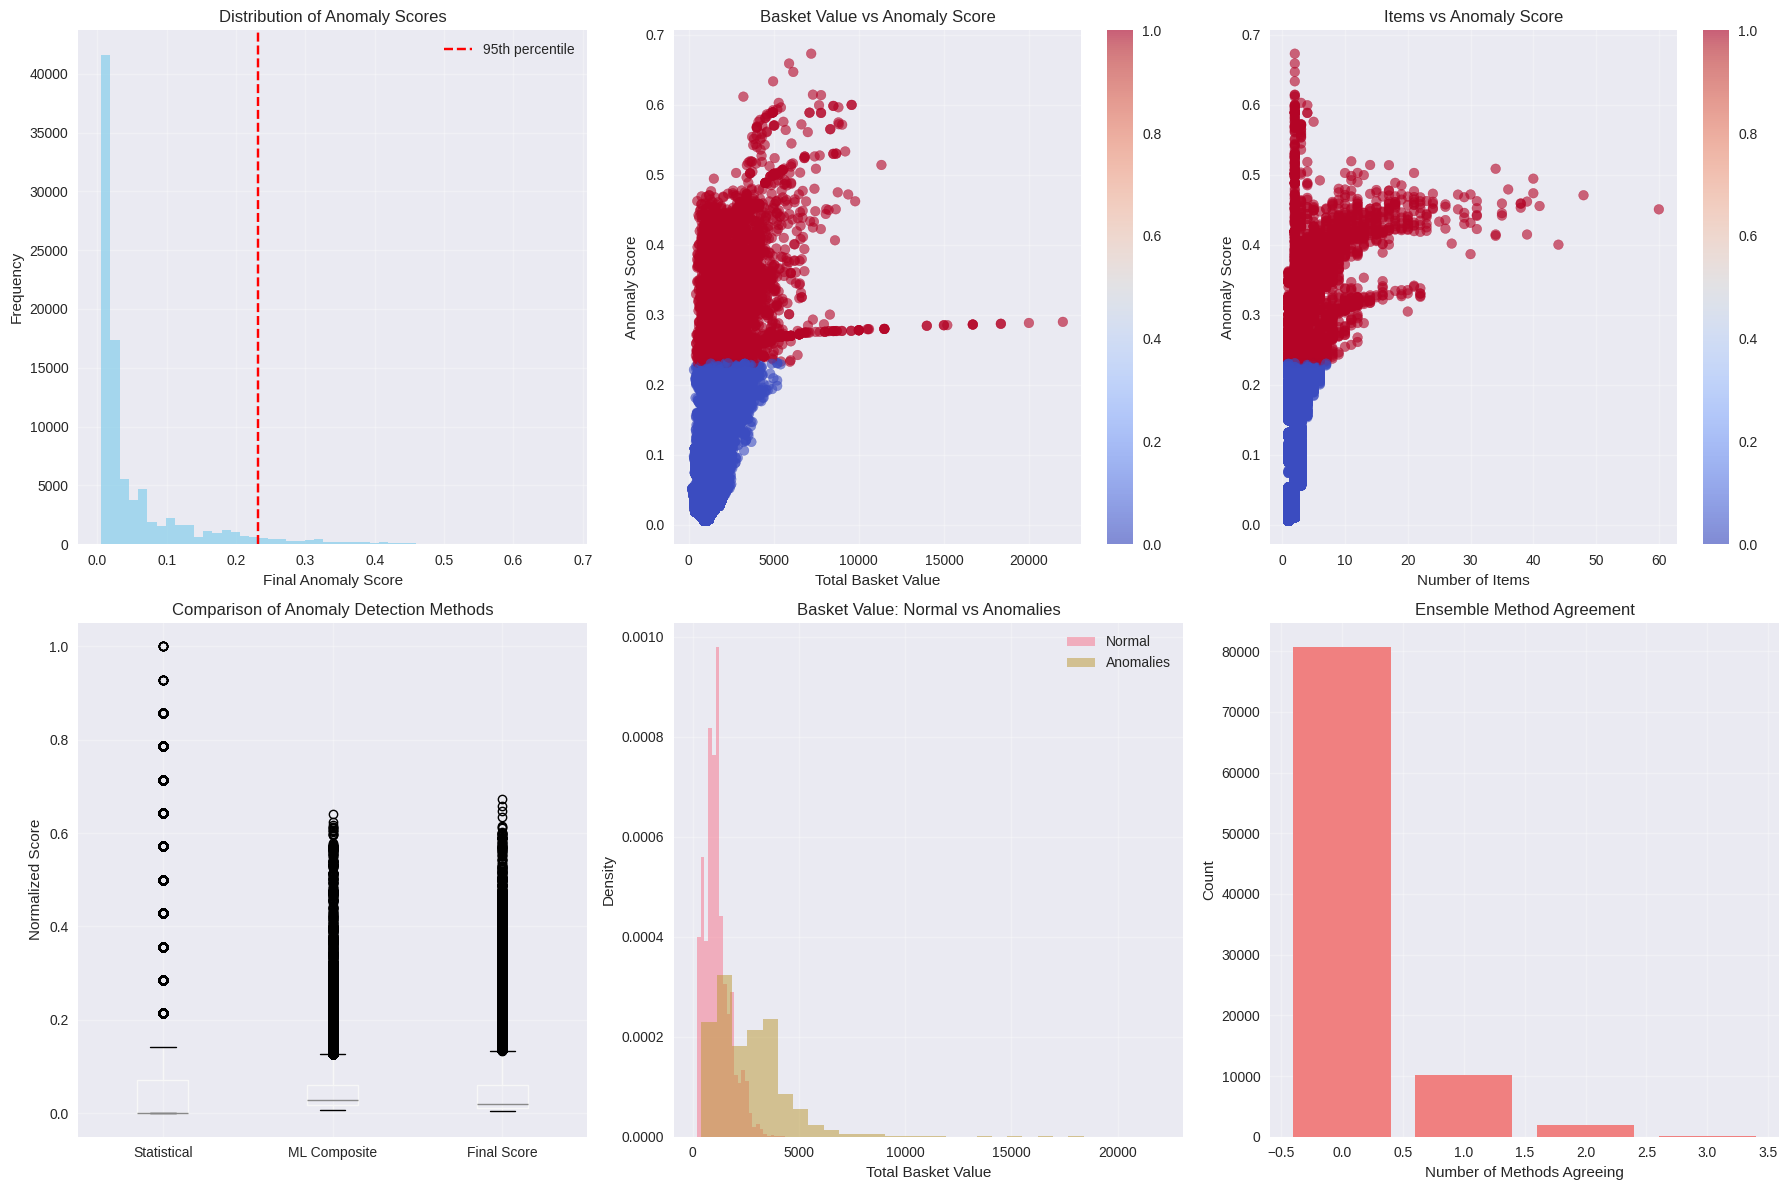

In [10]:
# Visualization of anomaly detection results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Anomaly score distribution
axes[0, 0].hist(
    final_anomaly_scores["final_anomaly_score"], bins=50, alpha=0.7, color="skyblue"
)
axes[0, 0].axvline(
    final_anomaly_scores["final_anomaly_score"].quantile(0.95),
    color="red",
    linestyle="--",
    label="95th percentile",
)
axes[0, 0].set_xlabel("Final Anomaly Score")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Distribution of Anomaly Scores")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Basket value vs anomaly score
scatter = axes[0, 1].scatter(
    final_anomaly_scores["total_basket_value"],
    final_anomaly_scores["final_anomaly_score"],
    c=final_anomaly_scores["is_anomaly"],
    cmap="coolwarm",
    alpha=0.6,
)
axes[0, 1].set_xlabel("Total Basket Value")
axes[0, 1].set_ylabel("Anomaly Score")
axes[0, 1].set_title("Basket Value vs Anomaly Score")
plt.colorbar(scatter, ax=axes[0, 1])
axes[0, 1].grid(True, alpha=0.3)

# 3. Number of items vs anomaly score
scatter2 = axes[0, 2].scatter(
    final_anomaly_scores["nb_items"],
    final_anomaly_scores["final_anomaly_score"],
    c=final_anomaly_scores["is_anomaly"],
    cmap="coolwarm",
    alpha=0.6,
)
axes[0, 2].set_xlabel("Number of Items")
axes[0, 2].set_ylabel("Anomaly Score")
axes[0, 2].set_title("Items vs Anomaly Score")
plt.colorbar(scatter2, ax=axes[0, 2])
axes[0, 2].grid(True, alpha=0.3)

# 4. Comparison of different methods
methods_comparison = pd.DataFrame(
    {
        "Statistical": final_anomaly_scores["statistical_score_norm"],
        "ML Composite": final_anomaly_scores["ml_composite_score"],
        "Final Score": final_anomaly_scores["final_anomaly_score"],
    }
)
methods_comparison.boxplot(ax=axes[1, 0])
axes[1, 0].set_title("Comparison of Anomaly Detection Methods")
axes[1, 0].set_ylabel("Normalized Score")
axes[1, 0].grid(True, alpha=0.3)

# 5. Anomaly characteristics
anomalies = final_anomaly_scores[final_anomaly_scores["is_anomaly"] == 1]
normal = final_anomaly_scores[final_anomaly_scores["is_anomaly"] == 0]

axes[1, 1].hist(
    normal["total_basket_value"], bins=30, alpha=0.5, label="Normal", density=True
)
axes[1, 1].hist(
    anomalies["total_basket_value"], bins=30, alpha=0.5, label="Anomalies", density=True
)
axes[1, 1].set_xlabel("Total Basket Value")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("Basket Value: Normal vs Anomalies")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Ensemble method agreement
ensemble_agreement = ml_results["ensemble_pred"].value_counts().sort_index()
axes[1, 2].bar(ensemble_agreement.index, ensemble_agreement.values, color="lightcoral")
axes[1, 2].set_xlabel("Number of Methods Agreeing")
axes[1, 2].set_ylabel("Count")
axes[1, 2].set_title("Ensemble Method Agreement")
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Apply to Test Data and Generate Results

Apply the trained models to the test dataset and generate the final submission file.


In [11]:
def apply_to_test_data(test_features, feature_scaler, trained_models=None):
    """
    Apply the anomaly detection pipeline to test data
    """
    # Statistical outlier detection on test data
    test_statistical = detect_statistical_outliers(test_features, method="iqr")

    # Prepare test features for ML
    test_ml_features = prepare_ml_features(test_features)
    test_scaled = feature_scaler.transform(test_ml_features)

    # Apply ML models (retrain on test - for unsupervised learning this is acceptable)
    test_ml_results, _ = apply_ml_anomaly_detection(test_features, contamination=0.05)

    # Create final scores for test data
    test_final_scores = create_final_anomaly_scores(
        test_features, test_statistical, test_ml_results
    )

    return test_final_scores


# Apply to test data
print("Applying anomaly detection to test data...")
test_anomaly_scores = apply_to_test_data(test_features, feature_scaler)

print(f"Test data anomaly detection results:")
print(f"Total test baskets: {len(test_anomaly_scores)}")
print(f"Test baskets flagged as anomalous: {test_anomaly_scores['is_anomaly'].sum()}")
print(f"Test anomaly rate: {test_anomaly_scores['is_anomaly'].mean():.3f}")

Applying anomaly detection to test data...
Applying Isolation Forest...
Applying Local Outlier Factor...
Applying One-Class SVM...
Test data anomaly detection results:
Total test baskets: 23198
Test baskets flagged as anomalous: 1160
Test anomaly rate: 0.050


In [12]:
# Generate final submission files

# Training results
train_submission = final_anomaly_scores[
    ["ID", "final_anomaly_score", "is_anomaly", "anomaly_rank"]
].copy()
train_submission.columns = ["ID", "anomaly_score", "is_anomaly", "rank"]
train_submission = train_submission.sort_values("anomaly_score", ascending=False)

# Test results
test_submission = test_anomaly_scores[
    ["ID", "final_anomaly_score", "is_anomaly", "anomaly_rank"]
].copy()
test_submission.columns = ["ID", "anomaly_score", "is_anomaly", "rank"]
test_submission = test_submission.sort_values("anomaly_score", ascending=False)

# Save results
train_submission.to_csv(RESULTS_PATH / "approach1_train_results.csv", index=False)
test_submission.to_csv(RESULTS_PATH / "approach1_test_results.csv", index=False)

print("Results saved to:")
print(f"- {RESULTS_PATH / 'approach1_train_results.csv'}")
print(f"- {RESULTS_PATH / 'approach1_test_results.csv'}")

# Display top anomalies from test data
print("\nTop 10 most anomalous baskets in test data:")
print(test_submission.head(10)[["ID", "anomaly_score"]].to_string(index=False))

Results saved to:
- results/approach1_train_results.csv
- results/approach1_test_results.csv

Top 10 most anomalous baskets in test data:
    ID  anomaly_score
  6092       0.658426
 51747       0.636206
 79621       0.623485
107166       0.617088
 81784       0.614850
 46343       0.607845
 97077       0.605126
 28498       0.604119
 35622       0.596353
 85966       0.592758


## Step 7: Feature Importance and Interpretability

Analyze which features contribute most to anomaly detection for business interpretation.


ANOMALOUS BASKETS CHARACTERISTICS:
                    Normal_Mean  Anomaly_Mean  Normal_Std  Anomaly_Std  \
nb_items               1.605173      4.790948    0.779510     4.645279   
total_basket_value  1159.154214   2671.098060  598.524896  1710.483553   
total_products         1.615621      6.379957    0.788356     6.719700   
unique_items           1.533318      2.784052    0.686257     2.023020   

                       Ratio  
nb_items            2.984693  
total_basket_value  2.304351  
total_products      3.948919  
unique_items        1.815704  

KEY FINDINGS:
- Anomalies have 2.98x higher nb_items on average
- Anomalies have 2.30x higher total_basket_value on average
- Anomalies have 3.95x higher total_products on average
- Anomalies have 1.82x higher unique_items on average


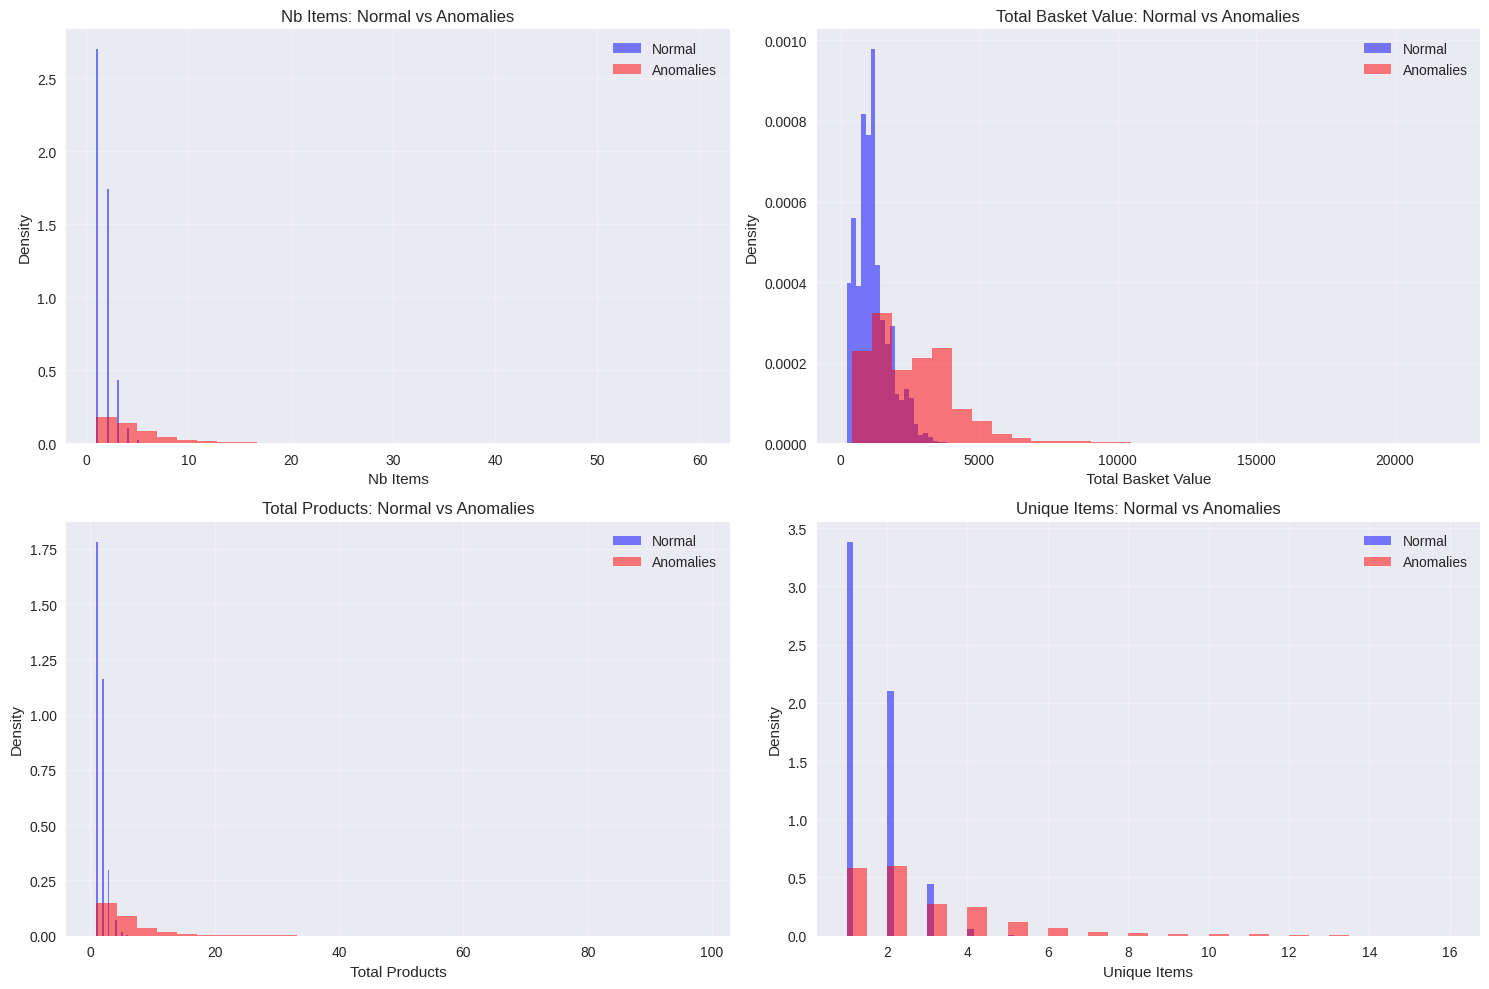

In [13]:
# Analyze feature importance for anomaly detection
def analyze_anomaly_characteristics(anomaly_scores, features):
    """
    Analyze characteristics of detected anomalies
    """
    anomalies = anomaly_scores[anomaly_scores["is_anomaly"] == 1]
    normal = anomaly_scores[anomaly_scores["is_anomaly"] == 0]

    print("ANOMALOUS BASKETS CHARACTERISTICS:")
    print("=" * 50)

    # Statistical comparison
    comparison_features = [
        "nb_items",
        "total_basket_value",
        "total_products",
        "unique_items",
    ]

    comparison_df = pd.DataFrame(
        {
            "Normal_Mean": normal[comparison_features].mean(),
            "Anomaly_Mean": anomalies[comparison_features].mean(),
            "Normal_Std": normal[comparison_features].std(),
            "Anomaly_Std": anomalies[comparison_features].std(),
        }
    )

    comparison_df["Ratio"] = (
        comparison_df["Anomaly_Mean"] / comparison_df["Normal_Mean"]
    )
    print(comparison_df)

    print("\nKEY FINDINGS:")
    for feature in comparison_features:
        ratio = comparison_df.loc[feature, "Ratio"]
        if ratio > 1.5:
            print(f"- Anomalies have {ratio:.2f}x higher {feature} on average")
        elif ratio < 0.67:
            print(f"- Anomalies have {1 / ratio:.2f}x lower {feature} on average")

    return comparison_df


# Analyze training data anomalies
feature_analysis = analyze_anomaly_characteristics(final_anomaly_scores, train_features)

# Create visualization of anomaly characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

features_to_plot = ["nb_items", "total_basket_value", "total_products", "unique_items"]
anomalies = final_anomaly_scores[final_anomaly_scores["is_anomaly"] == 1]
normal = final_anomaly_scores[final_anomaly_scores["is_anomaly"] == 0]

for i, feature in enumerate(features_to_plot):
    row, col = i // 2, i % 2

    axes[row, col].hist(
        normal[feature], bins=30, alpha=0.5, label="Normal", density=True, color="blue"
    )
    axes[row, col].hist(
        anomalies[feature],
        bins=30,
        alpha=0.5,
        label="Anomalies",
        density=True,
        color="red",
    )
    axes[row, col].set_xlabel(feature.replace("_", " ").title())
    axes[row, col].set_ylabel("Density")
    axes[row, col].set_title(
        f"{feature.replace('_', ' ').title()}: Normal vs Anomalies"
    )
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Business Insights

### Approach 1 Results:

This statistical and ensemble-based approach provides:

1. **Interpretable Results**: Clear understanding of why baskets are flagged as anomalous
2. **Multiple Detection Methods**: Combines statistical and ML-based approaches
3. **Robust Performance**: Uses ensemble methods to reduce false positives
4. **Business-Friendly**: Results can be easily explained to business stakeholders

### Key Anomaly Indicators Detected:

- Extremely high or low basket values
- Unusual quantity patterns
- Atypical item diversity
- Price-quantity mismatches

### Recommendations:

1. Focus investigation on baskets with composite scores > 95th percentile
2. Pay special attention to baskets flagged by multiple methods
3. Consider business context when interpreting results
4. Use feature importance analysis to guide fraud investigation priorities
